In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

En primera instancia se genera el código con el que se simulará la ciudad multinúcleo. Para ello, se utilizará una región determinada por el cuadrado: $[-100,100]^2$. En dicha zona se tendrán "comunas" centradas en las esquinas del cuadrado $[-40,40]^2$, en las que cada punto representa una casa, además habrá una distribución uniforme de casas esparcida en el cuadrado inicial, de forma de tener una especie de "casas de ruido" que no tienen porque pertenecer estrictamente a las comunas. Como el modelo de ciudad ocupado es el multinúcleo, se debe tener que cada "comuna" tenga en su centro puntos de interés (servicios o trabajos) y al mismo tiempo, en el centro de todo el esquema se acumulen aún más puntos de interés.

In [2]:
# Esta función se diseña para distribuir las estaciones iniciales y
# generar las regiones Voronoi correspondientes.
def inicializar_estaciones(N, xlim=100, ylim=100):
    
    angulo = 2 * np.pi / N
    coordenadas_x = [np.cos(i * angulo) for i in range(N)]
    coordenadas_y = [np.sin(i * angulo) for i in range(N)] # Se inician a partir de un polígono de N lados.
    p = np.random.normal(0, 40, 2 * N) # Y luego se desplazarán siguiendo una normal(0,40).

    points = []
    
    for i in range(N):
        x_coord = coordenadas_x[i] + p[i] # Desplazamos la primera coordenada según dicha normal,
        y_coord = coordenadas_y[i] + p[N + i] # Y la segunda.

        # Ajustamos las coordenadas para que estén dentro del cuadrado:
        x_coord = max(min(x_coord, xlim), -xlim)
        y_coord = max(min(y_coord, ylim), -ylim)

        points.append([x_coord, y_coord]) # Se agregan los puntos.

    points = np.array(points)
    return points

def inicializar_personas(mu,sig,n): # Cada comuna (conjunto de casas) se genera mediante una normal
    ciud = np.random.multivariate_normal(mu,sig,n) # multivariada.
    return ciud

def generar_comunas(xlim = 100,ylim = 100): #Esta función generará las comunas y sus respectivos puntos de interes.
    
    ciud_tot = []
    mus = [[xlim/3,ylim/3],[-xlim/3,ylim/3],[xlim/3,-ylim/3],[-xlim/3,-ylim/3]] #Los mus son de forma que las ciudades
    sig = [[xlim,3/4 * xlim],[3/4 * ylim, ylim]] #estén centradas en las esquinas de un cuadrado contenido en el inicial.
    sig_interes = [[xlim*0.2,xlim*0.1],[ylim*0.1,ylim*0.2]] #Parámetros para los puntos de interés.
    puntos_de_interes = []

    for j in range(4):
        numero = np.random.randint(100,10000) #El número de casas que tendrá cada comuna es aleatorio.
        numero = int(numero)
        numerointeres = int(np.floor(numero/100)) #El número de puntos de interés fue creado de forma de ser menor a las casas.
        ciud = inicializar_personas(mus[j],sig,numero)
        ciud_tot.append(ciud)
        interes = inicializar_personas(mus[j],sig_interes,numerointeres)
        puntos_de_interes.append(interes)
    
    interes = inicializar_personas([0,0],[[xlim,xlim*0.1],[ylim*0.1,ylim]],200) #Los puntos de interés centrales.
    puntos_de_interes.append(interes)
    x_5 = np.random.uniform(-100,100,500)
    y_5 = np.random.uniform(-100,100,500)
    ciud_5_ruido = np.array([[x_5[i],y_5[i]] for i in range(len(x_5))]) #Las casas distribuidas uniformemente.
    ciud_tot.append(ciud_5_ruido)
    
    return ciud_tot,puntos_de_interes

def graficar_todo(vor, ciud_tot, puntos_de_interes):
    est = vor.points
    fig, ax = plt.subplots()

    colores_ciudades = ['orange', 'red', 'green', 'purple', 'brown'] #Se busca que las comunas sean de estos colores.

    for i in range(len(ciud_tot)):
        ciud = ciud_tot[i]
        if i == len(ciud_tot) - 1:
            ax.scatter(ciud[:, 0], ciud[:, 1], color='brown', label='Casas uniformes')
        else:
            ax.scatter(ciud[:, 0], ciud[:, 1], color=colores_ciudades[i], label=f'Comuna {i}') #Se grafican las comunas.

    for j in range(len(puntos_de_interes)): #Se grafican los puntos de interés.
        interes = puntos_de_interes[j]
        if j == len(puntos_de_interes) - 1:
            ax.scatter(interes[:, 0], interes[:, 1], color='yellow', label='Puntos de Interés')
        else:
            ax.scatter(interes[:, 0], interes[:, 1], color='yellow')

    ax.scatter(est[:, 0], est[:, 1], color='blue', label='Estaciones') #Se grafican las estaciones.

    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=1, line_alpha=0.5, point_size=5) 
    #Se grafican las regiones de voronoi.

    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    plt.grid(True)

    lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(f'Distribución de casas separadas en {N} poliedros de Voronoi')
    plt.xlabel('Eje x')
    plt.ylabel('Eje y')
    plt.show()

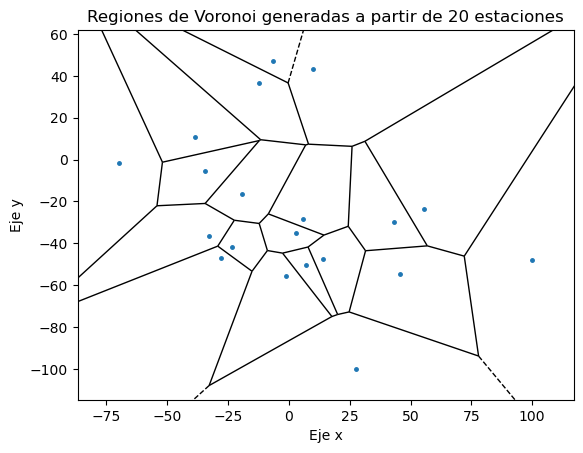

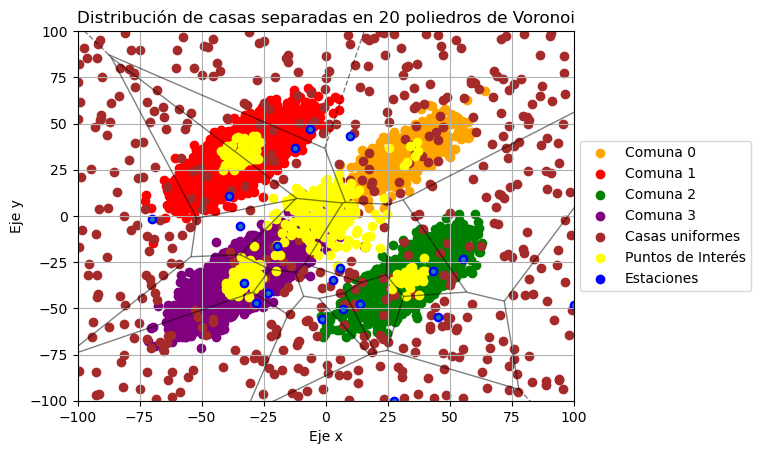

In [3]:
# Parámetros a cambiar.
N = 20 # Cantidad de estaciones.

ciud_tot,puntos_de_interes = generar_comunas()

est = inicializar_estaciones(N)

vor = Voronoi(est) #Esto generará los diagramas de Voronoi.
fig = voronoi_plot_2d(vor,show_vertices=False,point_size=5)
plt.title(f'Regiones de Voronoi generadas a partir de {N} estaciones')
plt.xlabel('Eje x')
plt.ylabel('Eje y')

graficar_todo(vor, ciud_tot, puntos_de_interes)

Tras esto, se crea una función que calcule las áreas de las regiones de Voronoi, lo que será importante para calcular la función objetivo. Acá es importante tener en cuenta que una región de Voronoi debe estar determinada por al menos 3 "esquinas" para tener un área distinta de 0.

In [4]:
# Tomaremos el conjunto de Voronois y un índice en particular que representa la región
# a la cual le calcularemos el área.
def areaf(vor, index): 

    region_vertices = vor.regions[index]
    # Filtramos los índices
    region_vertices = [idx for idx in region_vertices if idx >= 0 and idx < len(vor.vertices)]
    # para que estén dentro del rango de los vértices del Voronoi.
    # Eliminamos los duplicados.
    region_vertices = list(set(region_vertices))
    # Obtenemos las coordenadas de los vértices.
    region_coordinates = vor.vertices[region_vertices] 
    # Si los vértices son menores a 3 el área es 0.
    if len(region_coordinates) < 3:
        return 0
    # Si no, calculamos el área
    area = 0.5 * np.abs(np.dot(region_coordinates[:, 0], np.roll(region_coordinates[:, 1], 1)) -
                       np.dot(region_coordinates[:, 1], np.roll(region_coordinates[:, 0], 1))) 

    return area

Se definen las funciones anteobjetivo1 y anteobjetivo2, además de la función objetivo:


$$\sum_{i=1}^{n} \frac{10 \cdot n_{\text{casas}i}+50\cdot n_{\text{interes}i}}{A_i^2}$$

Donde el índice representa la región de Voronoi $i$, $n_{\text{casas}}$ y $n_{\text{interés}}$ representan el número de casas y de puntos de interés respectivamente.

In [5]:
def anteobjetivo(voronois,ciudades):
    contadores_por_region=[]
    # Exploramos todas las comunas.
    for point_set in ciud_tot:
        regions = [vor.point_region[np.argmin(np.linalg.norm(vor.points - point, axis=1))] for point in point_set] # Esto determina
        index=0 # qué puntos pertenecen a alguna región en particular, no se especifíca cuál es cada punto 
        # (sin embargo se hace en orden), pero cada región se repetirá por cada casa que haya en ella.
    # Explorando regions el region_index indica una casa en dicha región.
    for region_index in regions:
        index=region_index
        dato=[10,index] # Utilizamos que cada casa vale 10.
        contadores_por_region.append(dato)
            
    return contadores_por_region

def anteobjetivo2(voronois,puntos_de_interes):
    contadores_por_region=[]

    for  point_set in puntos_de_interes:
        regions = [vor.point_region[np.argmin(np.linalg.norm(vor.points - point, axis=1))] for point in point_set]
        index=0
        
    for region_index in regions:
        index=region_index
        dato=[50,index] # Es ánalogo al anterior, pero los puntos de interés valen 50.
        contadores_por_region.append(dato)
            
    return contadores_por_region

# Función objetivo.
def objetivo(voronoi, ciudades, puntos_de_interes):
    
    cont = anteobjetivo(voronoi, ciudades)
    cont_interes = anteobjetivo2(voronoi,puntos_de_interes) #Se obtienen los datos de las funciones anteriores.
    valores = []
    
    for i, region in enumerate(voronoi.regions):
        area = areaf(voronoi, i) # Calculamos el área de cada región

        if area > 0:  # Verificamos si el área es mayor que cero para evitar divisiones por cero
            valores_k = [dato[0] for dato in cont if i == dato[1]] # Por cada región hacemos listas con los respectivos valores
            valores_interes = [dato[0] for dato in cont_interes if i == dato[1]] # que tendrá en su interior.
            valor_final = sum(valores_k) / (area)**2 + sum(valores_interes) / (area)**2 # La fórmula de la función objetivo
            # el 10 y el 50 que multiplican fueron considerados antes.
            valores.append(valor_final)

    total = sum(valores) # Se entrega la sumatoria de los valores calculados.
    return total


Se fija la semilla:

In [6]:
# Parámetros a cambiar.
semilla = 42

Y se procede a utilizar el método de Metropolis-Hastings para obtener la mejor distribución, para ello es importante notar que debemos maximizar la función objetivo y que un nuevo estado se generará de la siguiente forma: consideraremos un punto aleatorio de los que determinan las regiones de Voronoi, luego perturbaremos dicho punto mediante una variable normal de media 0 y varianza 10, teniendo cuidado con que el punto se salga del cuadrado $[-100,100]^2$ o con que dos estaciones queden muy cerca, en ambos casos se deja el punto original sin modificar.

In [7]:
# La función de perturbación.
def random_perturbation(point,idx,todoslospoints, scale=10,xlim=100,ylim=100,epsilon=10,delta=80):
    #El punto perturbado.
    perturbation = point + np.random.normal(0, scale, point.shape)
    puntossinpoint = todoslospoints.copy()
    puntossinpoint = np.delete(puntossinpoint,idx,axis = 0)
    # Para verificar que no está demasiado cerca de otra estación.
    dist = np.min([np.linalg.norm(perturbation-point2) for point2 in puntossinpoint]) 
    
    if np.abs(perturbation[0])>xlim or np.abs(perturbation[1])>ylim: #Si es que se escapa del cuadrado inicial
        return point
    elif dist < epsilon: #Si dos estaciones quedan muy cerca.
        return point
    else:
        return perturbation

#Para graficar las regiones de Voronoi.
def plot_voronoi(vor):
    voronoi_plot_2d(vor)
    plt.plot(points[:, 0], points[:, 1], 'ro')  #Pintamos los puntos de origen
    plt.title(f"Regiones de Voronoi para i={i+1}")
    plt.show()

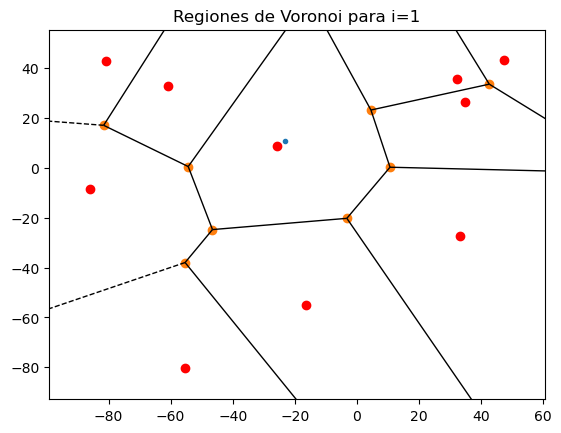

1 0
0.07183806547602424 0


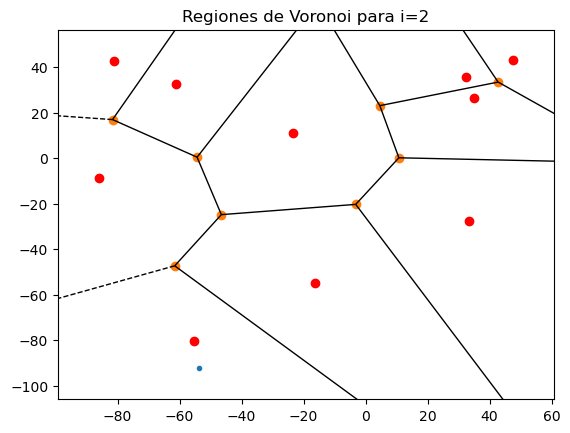

1 1
112.84251514798488 1


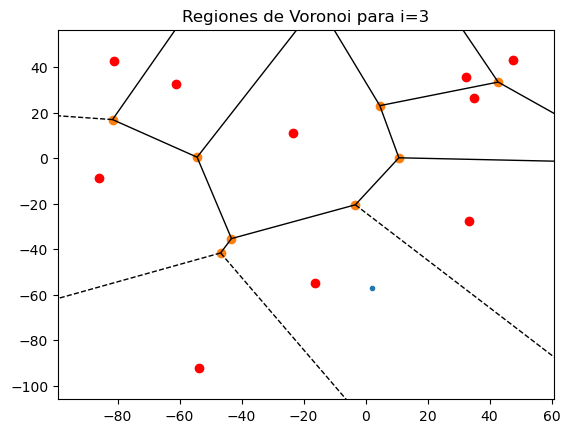

0.0009660545430256229 2


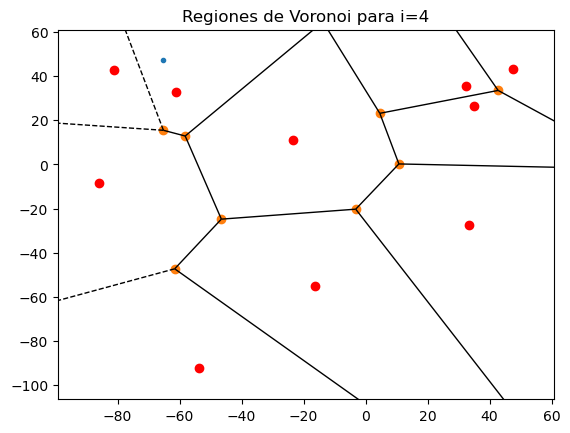

0.0002467426736695314 3


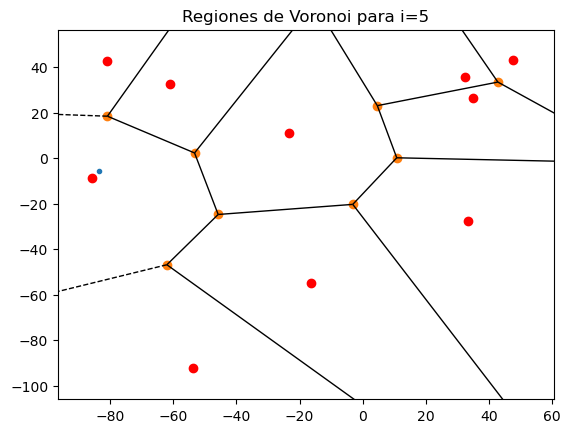

0.02978490797519692 4


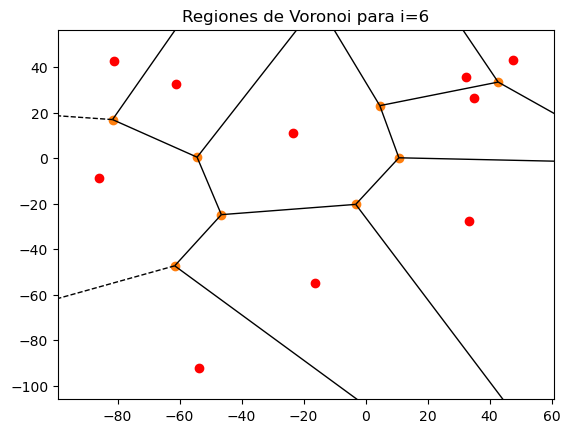

1 5
119.52648863478449 2


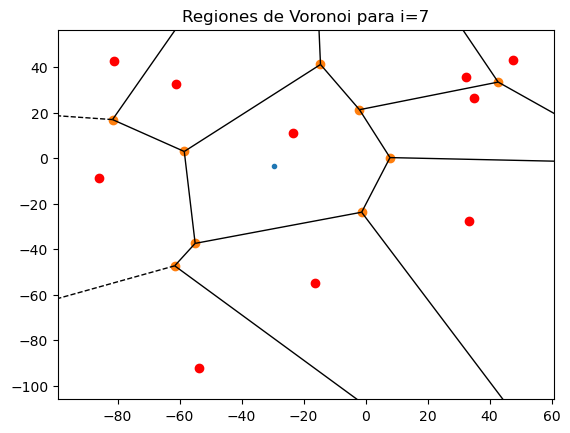

8.899755068971634e-05 6


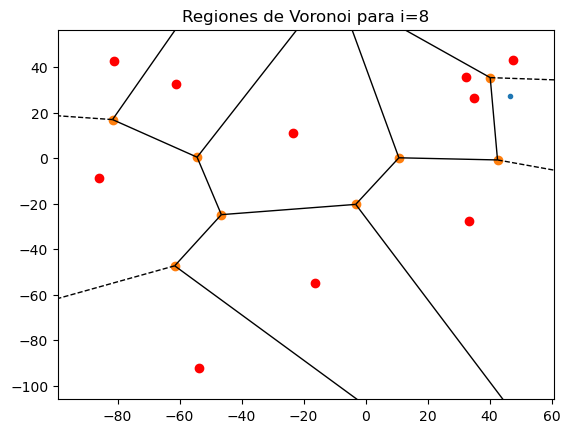

0.9585870612676612 7
114.57654548406057 3


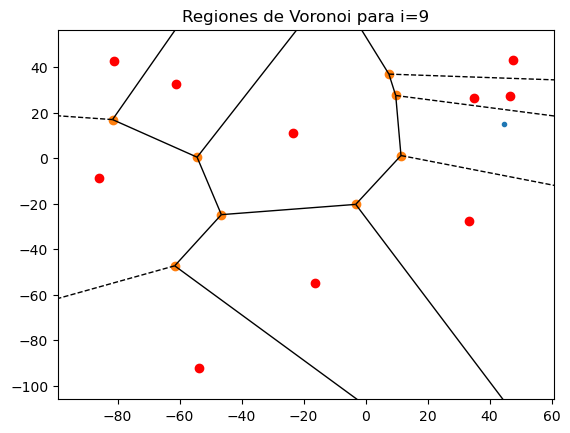

1 8
119.47447331688065 4


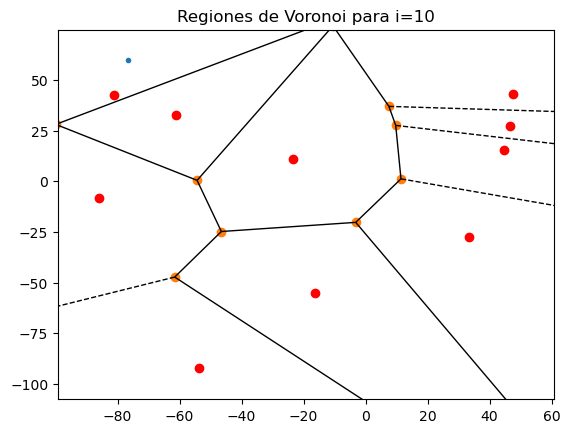

0.003280537259932833 9


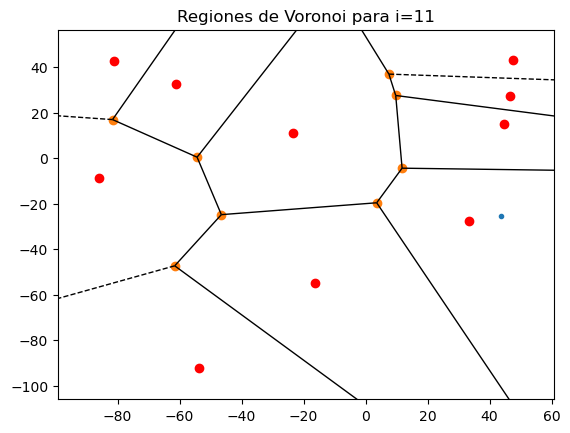

1 10
119.7538461013109 5


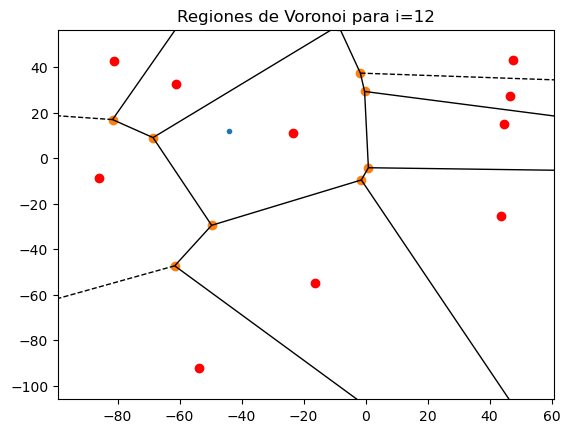

0.002313927663415226 11


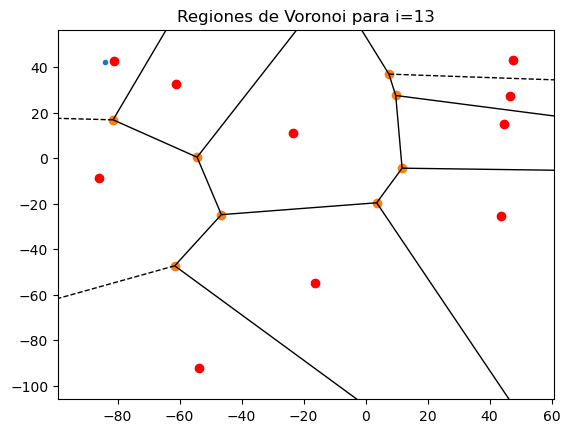

1 12
9679314.929347632 6


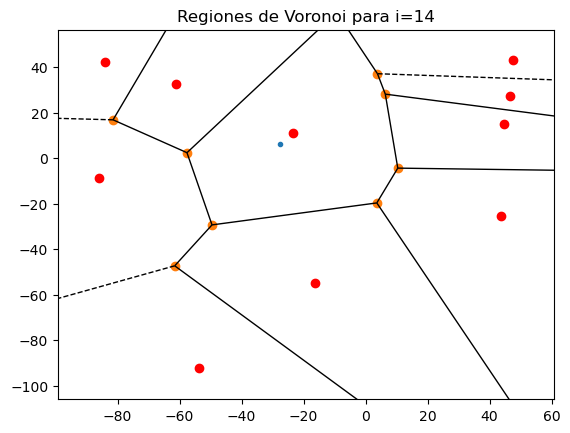

2.5698825336881555e-08 13


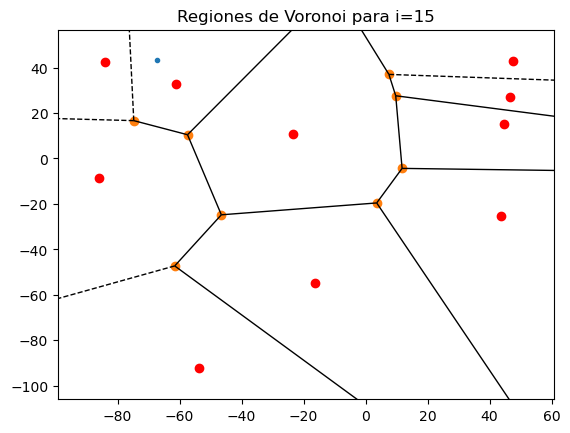

3.035437705228252e-08 14


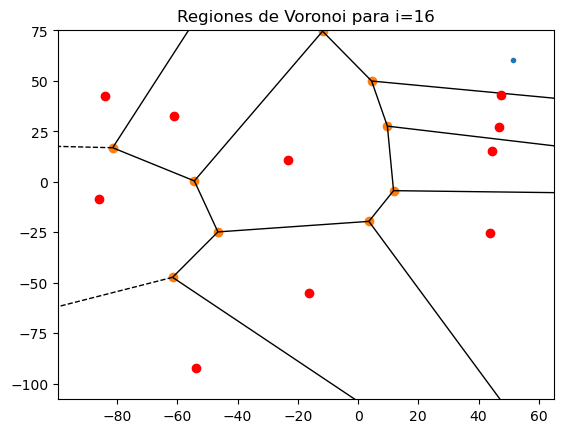

1 15
10485924.10279264 7


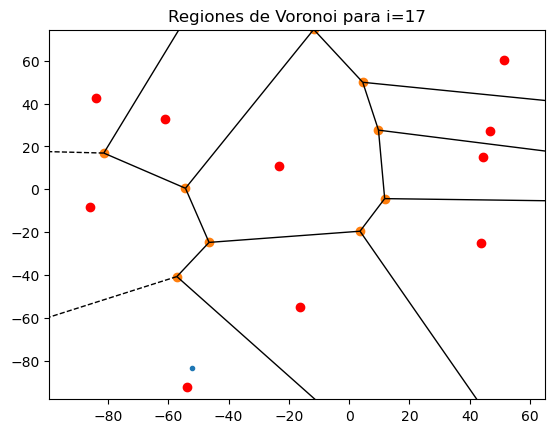

5.7439193363822455e-09 16


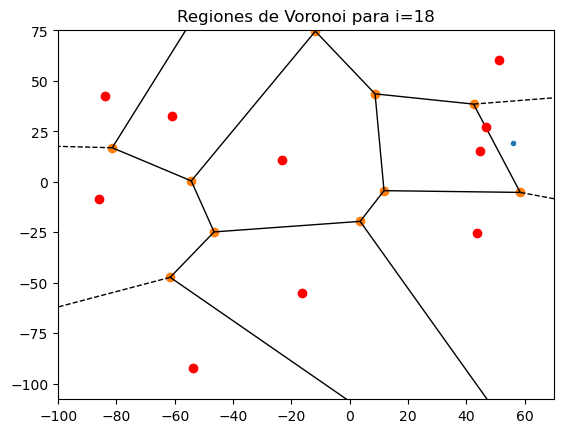

3.747501606334442e-07 17


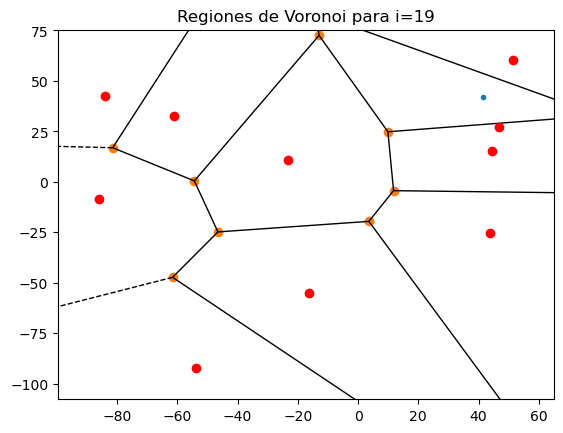

9.892631163030669e-11 18


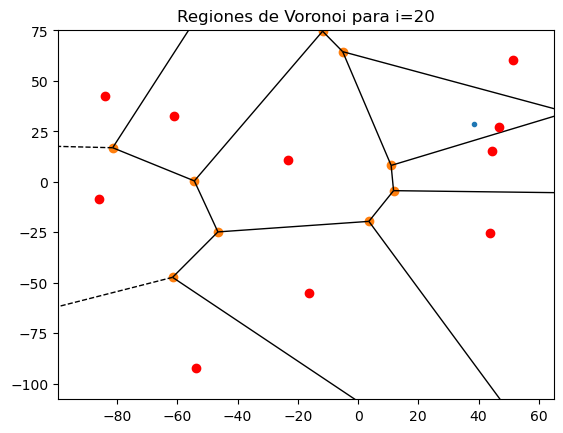

0.923076923688992 19
9679314.562842082 8


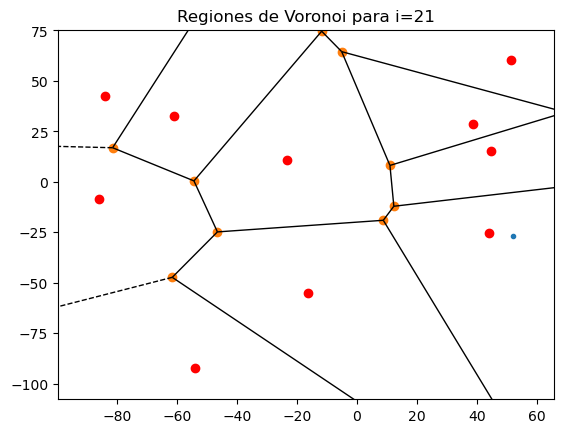

3.1138789965243e-09 20


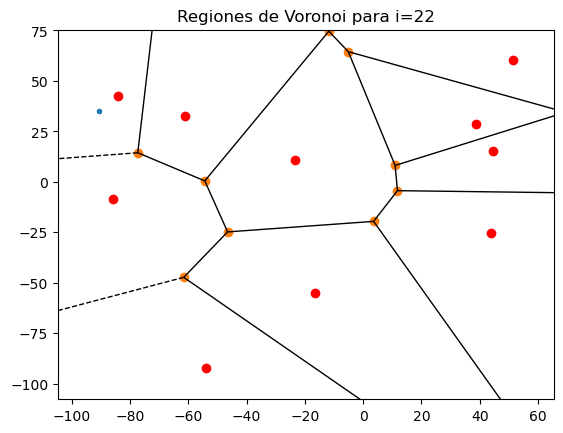

2.1219789791680072e-10 21


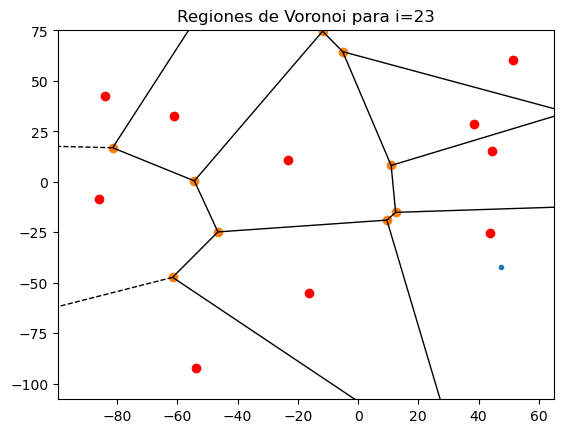

2.6902585371234743e-09 22


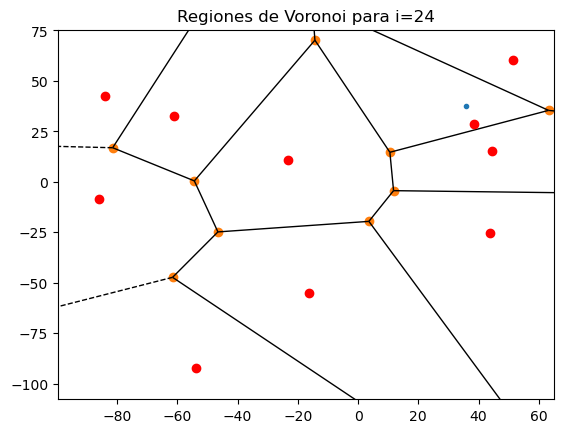

9.842550262607455e-11 23


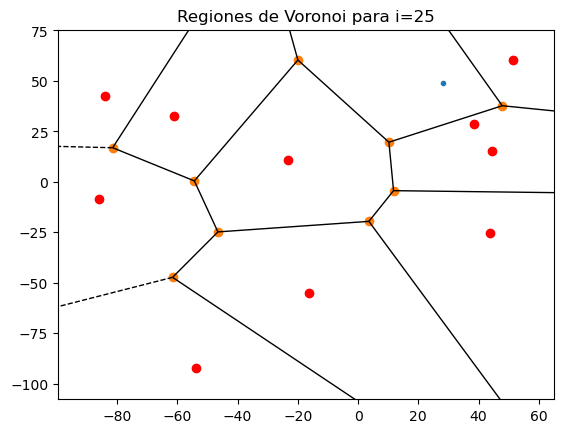

0.9999999994294018 24
9679314.557319082 9


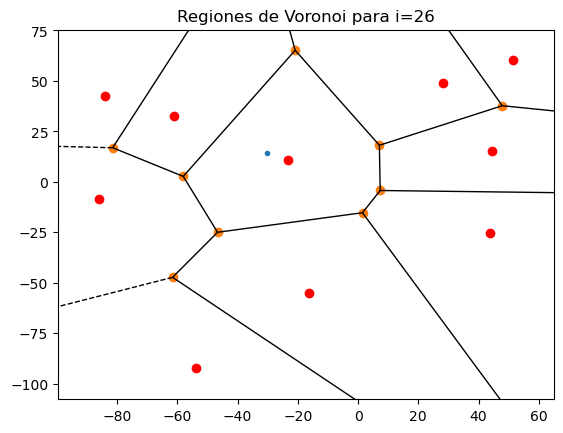

5.224773687552724e-09 25


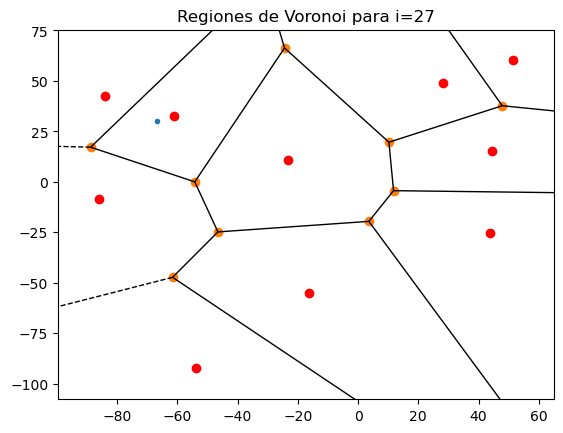

5.142662136590375e-09 26


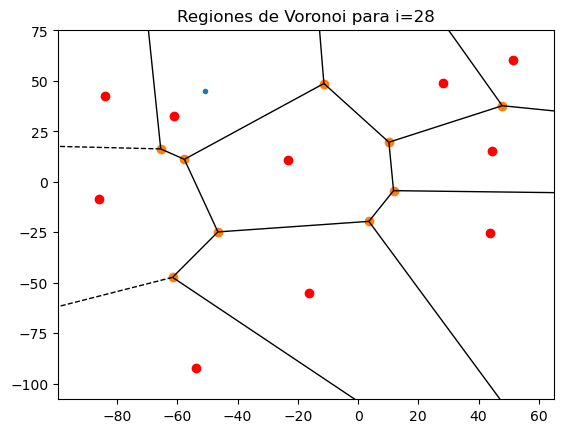

2.2648024123679933e-10 27


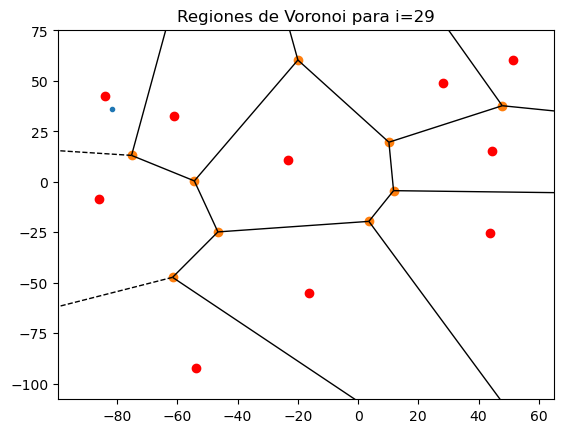

9.500480035767764e-09 28


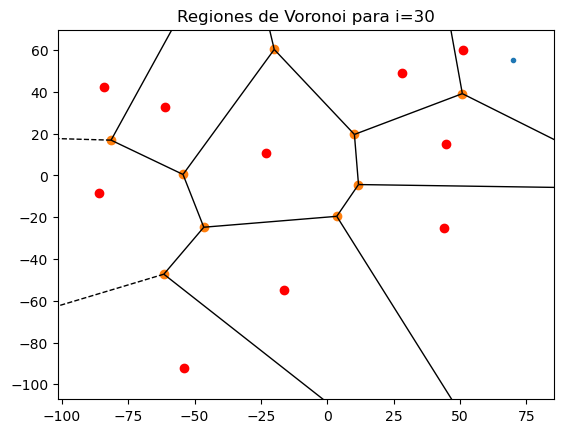

1 29
17207670.327066746 10


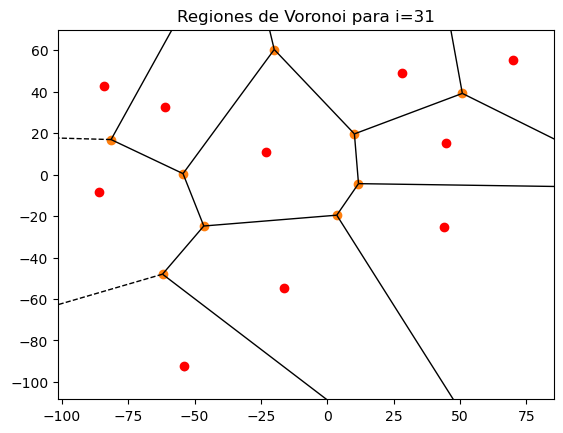

2.455695047615355e-07 30


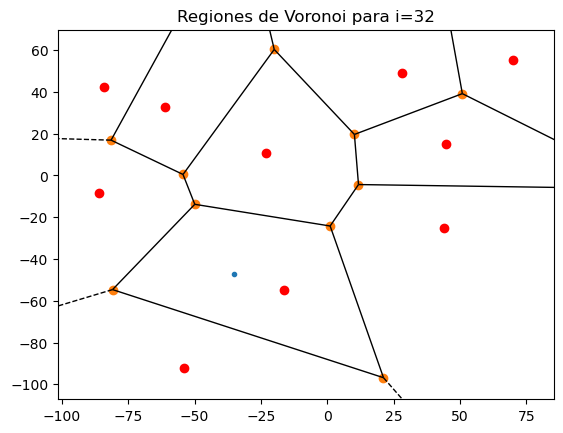

1.7174184539313088e-09 31


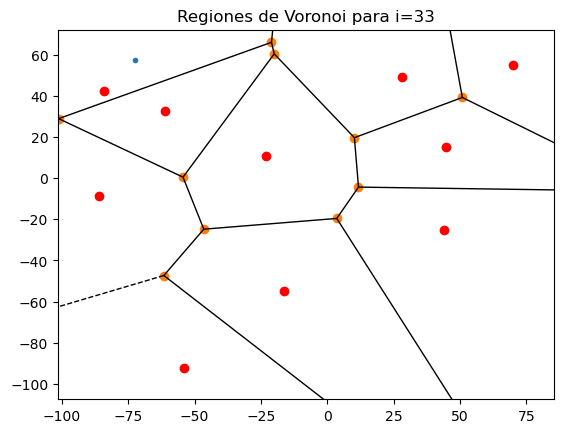

2.4274562858439994e-09 32


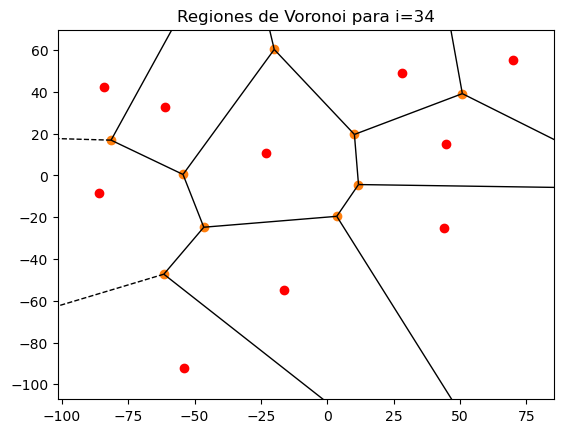

0.5625000003370623 33
9679314.5647751 11


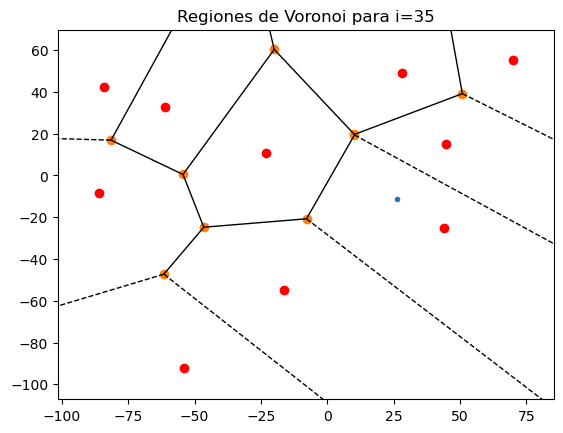

1 34
9679345.580003724 12


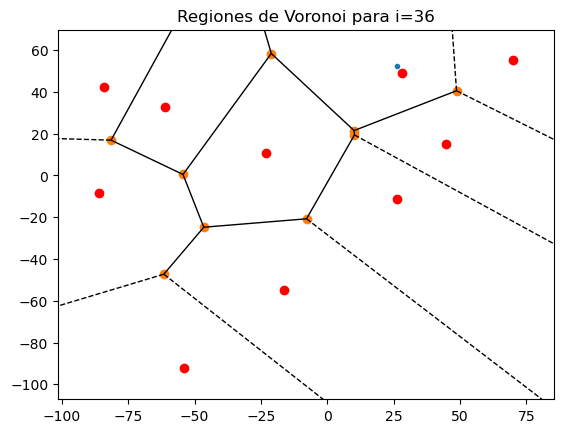

0.999996820437701 35
9679314.803921439 13


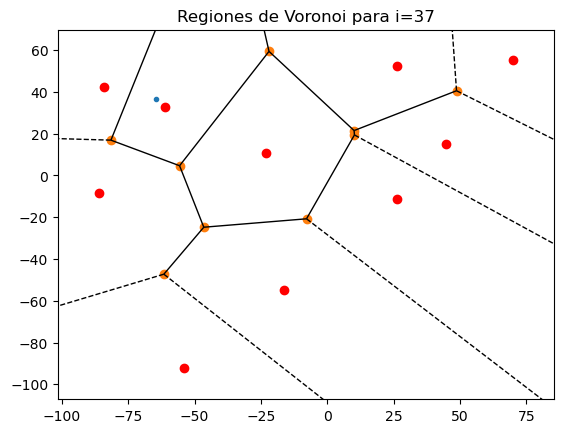

4.942223992264519e-05 36


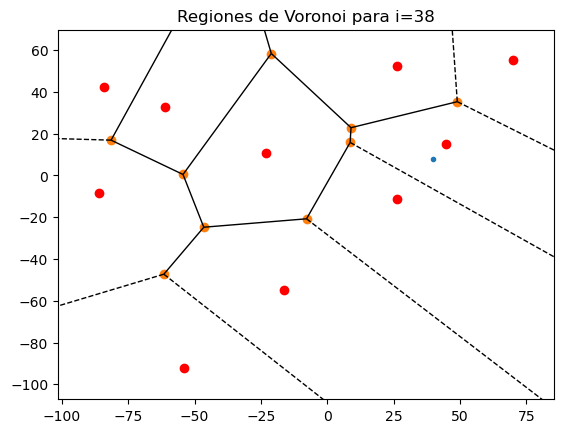

0.9999999791671178 37
9679314.602273414 14


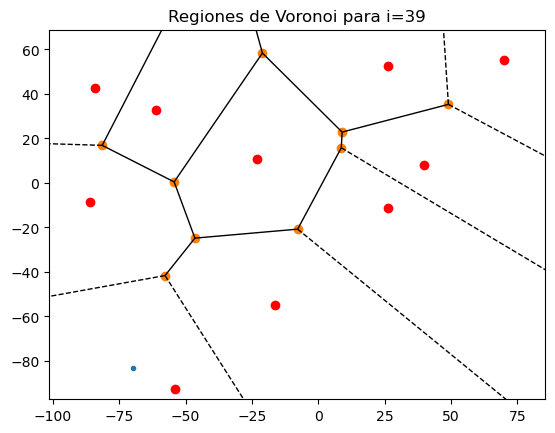

1.3804516018629555e-08 38


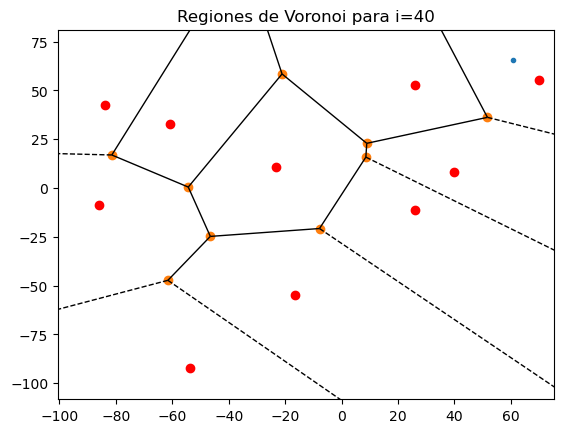

0.9999999987384662 39
9679314.590062631 15


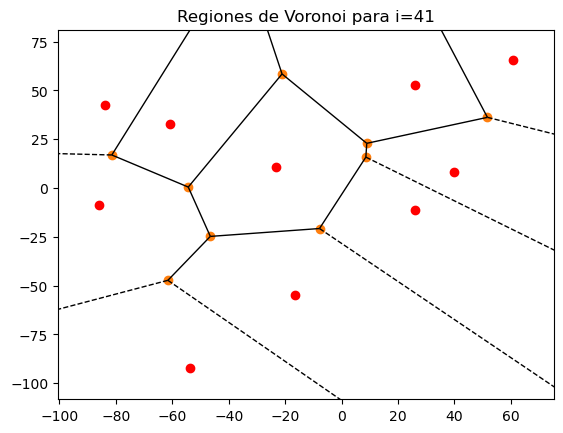

1 40
9679314.592308417 16


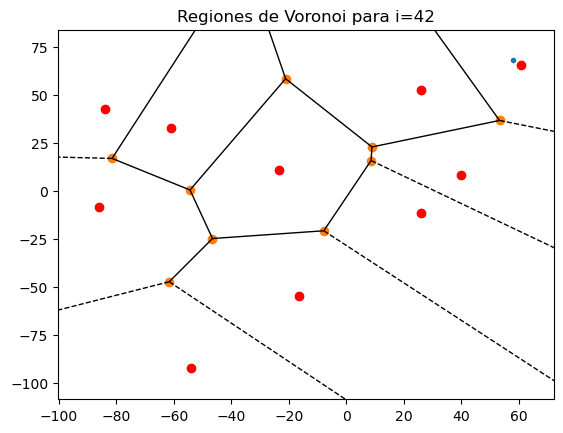

0.9999999998093563 41
9679314.590463117 17


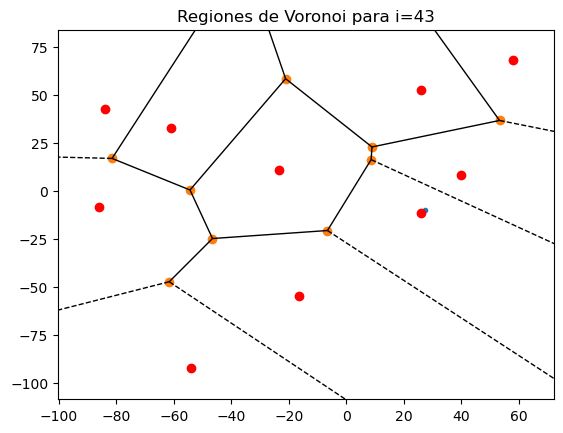

1 42
9679314.594958875 18


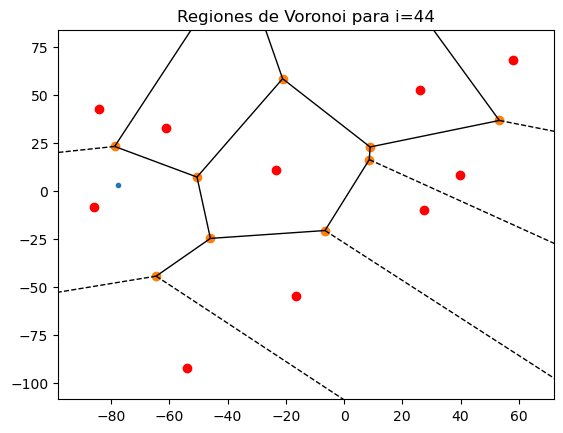

3.206623176299439e-08 43


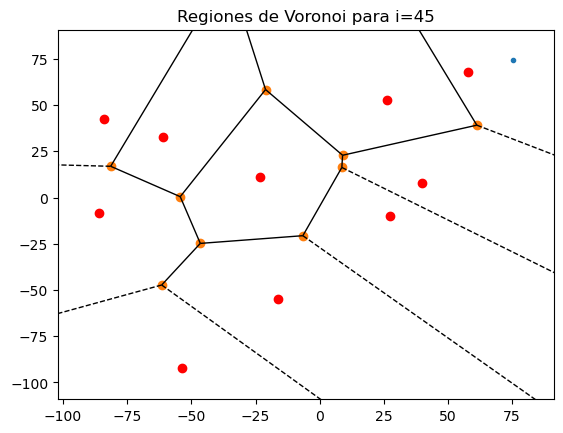

1 44
10217054.262491742 19


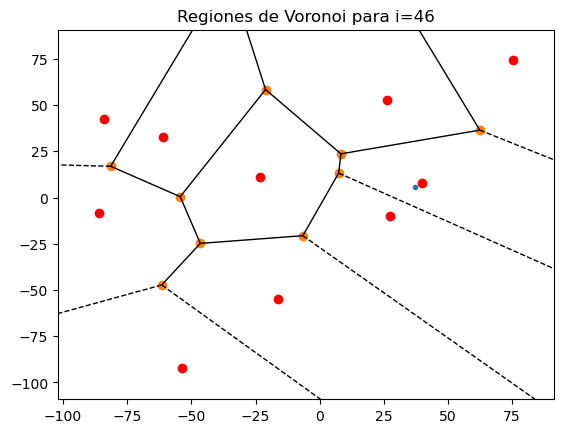

0.9473684218282108 45
9679314.572389996 20


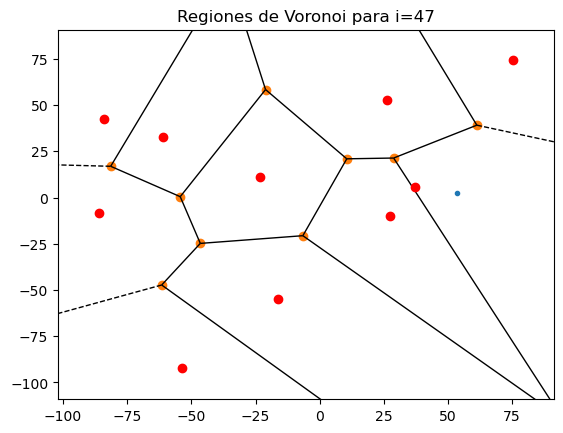

2.8658595009706586e-10 46


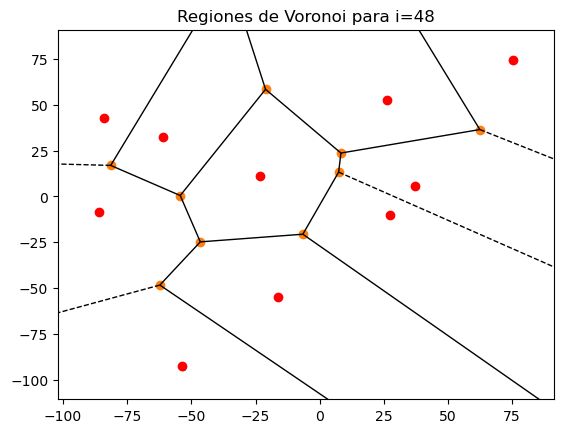

1.39117881817179e-09 47


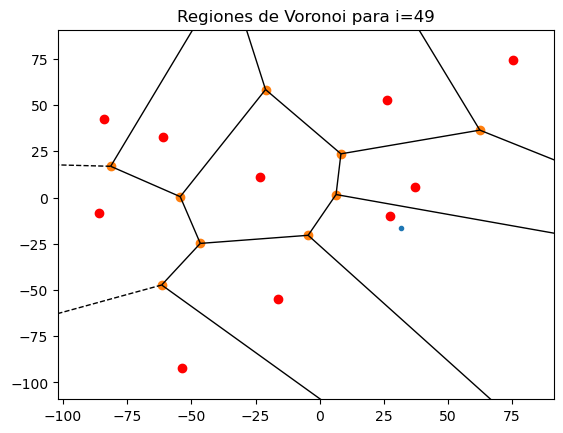

3.4427858740468293e-10 48


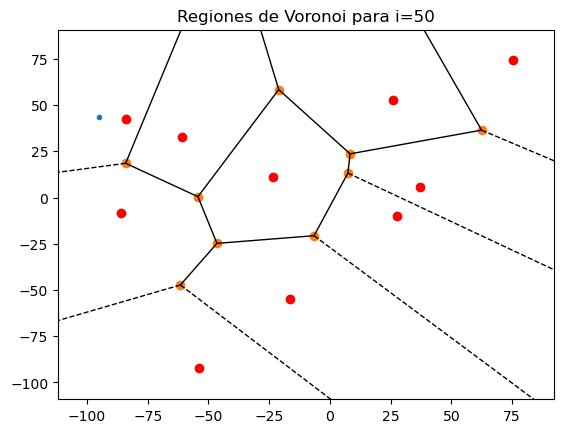

1.1698503176965202e-07 49


In [8]:
# Parámetros a cambiar.
N = 10
num_iterations = 50 # Número de iteraciones.

points = inicializar_estaciones(N) # Distribución inicial de regiones.
vor = Voronoi(points)
inicial = vor # Se deja una copia de la distribución inicial para luego graficar y comparar.

j=0 # Un contador.
objs = [] # Para realizar programación dinámica, contendrá los valores de la función objetivo.
for i in range(num_iterations): # No ocuparemos directamente una matriz que represente la cadena de Markov, sin embargo
    # en cada paso se iría generando la fila i de dicha matriz y el procedimiento sigue funcionando.
    if i == 0: # El caso base
        obj = objetivo(vor,ciud_tot,puntos_de_interes) # Calculamos la función objetivo de la dist. inicial y lo agregamos
        objs.append(obj) # a la lista.

    idx = np.random.randint(len(points)) # seleccionamos un punto aleatorio.
    selected_point = points[idx]
    proposal_point = random_perturbation(selected_point,idx,points) # lo perturbamos
    proposal_points = np.copy(points) # La distribución nueva.
    proposal_points[idx] = proposal_point
    vor_proposal = Voronoi(proposal_points) # Determinamos las regiones de voronoi nuevas.
    obj = objs[-1] # Extraemos el último elemento agregado a la lista con las funciones objetivo.
    obj_proposal = objetivo(vor_proposal,ciud_tot,puntos_de_interes) # Calculamos el valor objetivo de la nueva distribución
    acceptance_prob = min(1, obj_proposal / obj) # el mínimo entre 1 y la fn objetivo de la nueva dist. partido la anterior.
    plot_voronoi(vor_proposal) # Se grafica antes de ver si se acepta la distribución para ver más que nada cuando
    # lo está rechazando.
    print(acceptance_prob,i) #Se printea la aceptación y el índice.

    if np.random.rand() < acceptance_prob: # Metropolis-Hastings.
        
        objs.append(obj_proposal) # Se agrega a la lista si cumple la condición
        print(obj_proposal,j) # Se printea la fn objetivo nueva y el índice.
        points = proposal_points # Se actualiza la distribución a la nueva distribución encontrada.
        vor = vor_proposal # Se actualiza la distribución a la nueva distribución encontrada.
        j+=1

Se grafican la distribución inicial y final para ver el cambio.

inicial es el primer gráfico, final, el segundo
Las funciones objetivos de ambos son:  0.02173454505558565 9679314.572389996 respectivamente


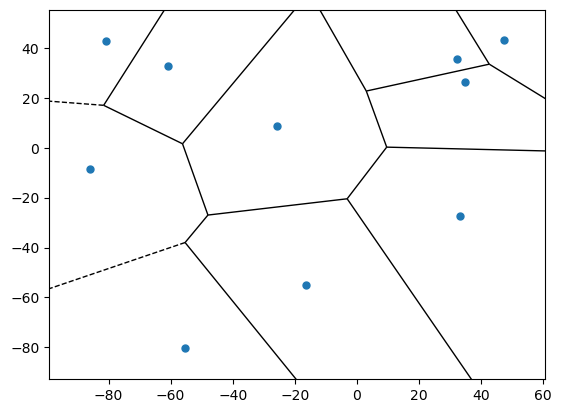

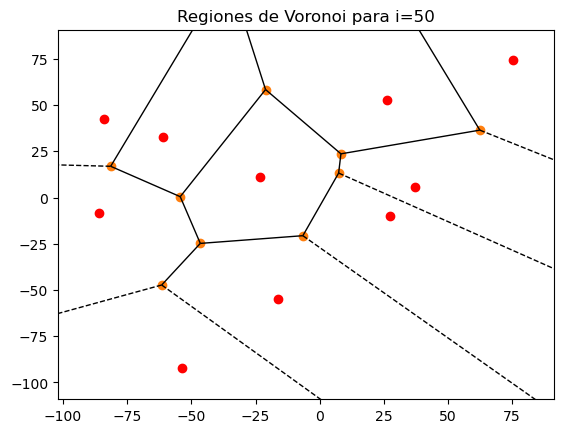

In [9]:
print("inicial es el primer gráfico, final, el segundo")
print("Las funciones objetivos de ambos son: ",objs[0],objs[-1],"respectivamente")
fig = voronoi_plot_2d(inicial,show_vertices=False,point_size=10)
plot_voronoi(vor)

Tras esto se grafican ambos considerando la distribución de casas y puntos de interés de la ciudad.

inicial


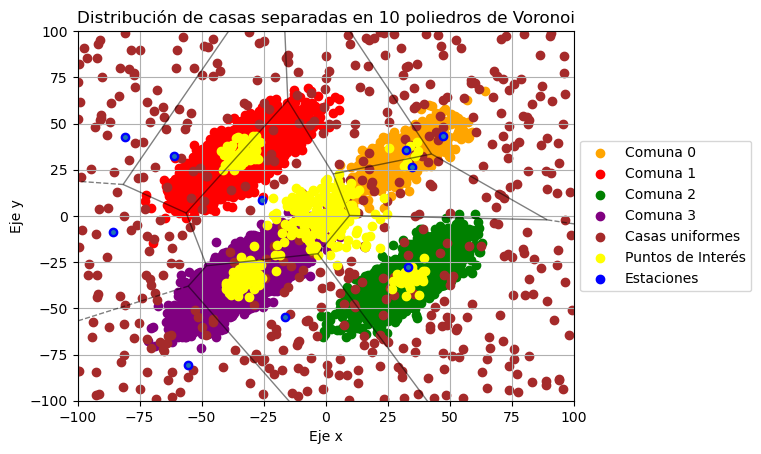

In [10]:
print("inicial")
graficar_todo(inicial,ciud_tot,puntos_de_interes)

final


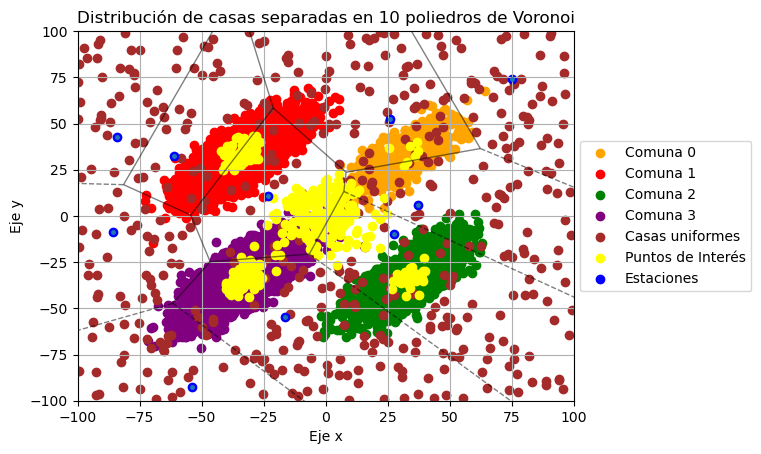

In [11]:
print("final")
graficar_todo(vor,ciud_tot,puntos_de_interes)

Es importante notar que los Voronoi tienden a desplazarse al centro, pues hay una mayor prioridad en abarcar los puntos de interés al tener más peso que las casas (esto se evidencia claramente en la región central). 

Finalmente, para obtener la ruta óptima, se utilizan las funciones del laboratorio 3.

In [12]:
# Calcula la distancia entre ciudades.
def distancia_ciudades(ciudades):
    D = np.zeros((N,N),dtype=float)
    for i in range(N):
        for j in range(N):
            D[i,j] = np.linalg.norm(ciudades[i]-ciudades[j])
    return D

In [13]:
from matplotlib.patches import FancyArrowPatch

#Una herramienta para visualizar mejor la ruta generada.
def arrow(x,y,ax,n):
    d = len(x)//(n+1)
    ind = np.arange(d,len(x),d)
    for i in ind:
        ar = FancyArrowPatch ((x[i-1],y[i-1]),(x[i],y[i]),
                              arrowstyle='->', mutation_scale=20)
        ax.add_patch(ar)

# Dada una permutación de las estaciones indica el camino respectivo a dicha permutación.
def recorre(ciudades,sigma):
    N = len(ciudades)
    M = len(sigma)
    assert N == M+1
    X,Y = np.matrix.transpose(ciudades)
    W = np.zeros(N+1)
    Z = np.zeros(N+1)
    W[0] = X[0]
    Z[0] = Y[0]
    for i in range(1,N):
        W[i] = X[sigma[i-1]]
        Z[i] = Y[sigma[i-1]]
    W[N] = W[0]
    Z[N] = Z[0]
    fig, ax = plt.subplots(figsize=(10,7))
    #ciudad inicial
    ax.plot(W[0],Z[0],"X",markersize=15,linestyle = '-', label = "estación " + str(1))
    for i in range(1,N):
        ax.plot(W[i],Z[i],"o",linestyle = '-', label = "estación " + str(i+1))
    #completar el ciclo

    ax.grid()
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)
    ax.title.set_text("Trayectoria seleccionada para " + str(N) +" estaciones")
    ax.legend(bbox_to_anchor=(1.1,1.001))
    arrow(W,Z,ax, N-1)

[[ 26.09225723  52.63940111]
 [-60.9937293   32.57521085]
 [-85.88162682  -8.47274074]
 [ 75.21638655  74.12742139]
 [ 37.20684019   5.7001448 ]
 [-23.26616139  10.91708303]
 [-16.40502479 -54.94196881]
 [-84.00830886  42.53976491]
 [ 27.53666753  -9.99547898]
 [-53.83852097 -92.43610182]]


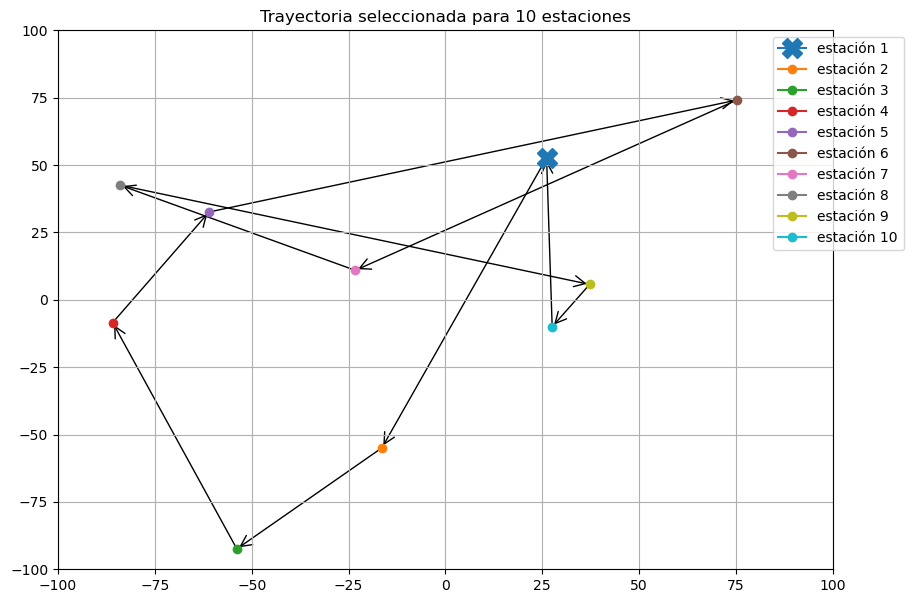

In [14]:
estaciones = vor.points
print(estaciones)
largo = len(estaciones)
sigma = np.random.permutation([i for i in range(1,largo)])
recorre(estaciones,sigma) # Para probar cómo se ve una ruta dada por alguna permutación.

Esto se utiliza más que nada como ejemplo de como se visualiza un posible camino.

Tras esto, se ocupa Simulated Annealing para obtener la ruta óptima.

In [15]:
def distancia_rec(ciudades,sigma):
    n = len(sigma)
    ciudades_ordenadas_sigma = np.zeros((n,2))
    for j in range(n):
        ciudades_ordenadas_sigma[j] = ciudades[int(sigma[j])]

    distancia =  sum(np.linalg.norm( ciudades_ordenadas_sigma[i] - ciudades_ordenadas_sigma[i+1]) for i in range(0,n-1))
    return distancia

def escoge(n,ciudades,tau,sigma, beta_n):
    osc_tau_sigma = (distancia_rec(ciudades,tau) - distancia_rec(ciudades,sigma))
    Cte_final = min(np.exp(-1*beta_n*osc_tau_sigma),1)
    if Cte_final == 1:
        return tau
    elif Cte_final<1:
        return sigma

def genera_beta_n_enunciado(n):
    return [np.log(i+np.e)/C for i in range(n)]

def generar_tau(sigma):
    n = len(sigma)
    a = np.random.randint(n)
    b = np.random.randint(n)
    tau = sigma.copy()
    (tau[a],tau[b]) = (tau[b],tau[a])
    return tau

def simular_cadena(N_limite, ciudades, estado_inic,beta_n):
    n = len(estado_inic)
    Cadenota = np.zeros((N_limite,n),dtype=int)
    Cadenota[0] = estado_inic
    for i in range(1,N_limite):
        beta_actual = beta_n[i]
        tau = generar_tau(Cadenota[i-1])
        Cadenota[i] = escoge(i, ciudades, tau, Cadenota[i-1],beta_actual)
    return Cadenota

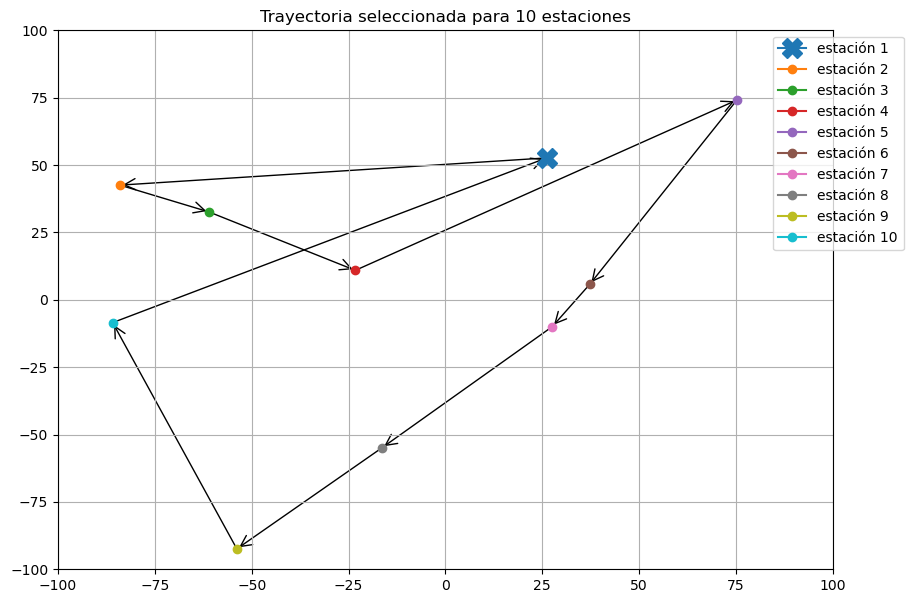

In [16]:
# Parámetros a cambiar.
N_markov = 600 # Pasos de la cadena de markov
C = (N-1)*N*np.sqrt(2) # Constante
#osc_K(w) <= N*raiz(2), cota
beta_n_test = [np.log(i+np.e)/C for i in range(N_markov)]

sigma_inicial = np.random.default_rng(seed=semilla).permutation([i for i in range(1,N)])

matriz = simular_cadena(N_markov,estaciones,sigma_inicial,beta_n_test)

# Graficamos la ruta óptima obtenida para las estaciones:
sigma_f = matriz[-1]
recorre(estaciones,sigma_f)

Y ahora verificamos como evoluciona la cadena con un beta lineal, cuadrático y exponencial.

C:\Users\nico_\AppData\Local\Temp\ipykernel_14936\3047871367.py:12: RuntimeWarning: overflow encountered in exp
  Cte_final = min(np.exp(-1*beta_n*osc_tau_sigma),1)


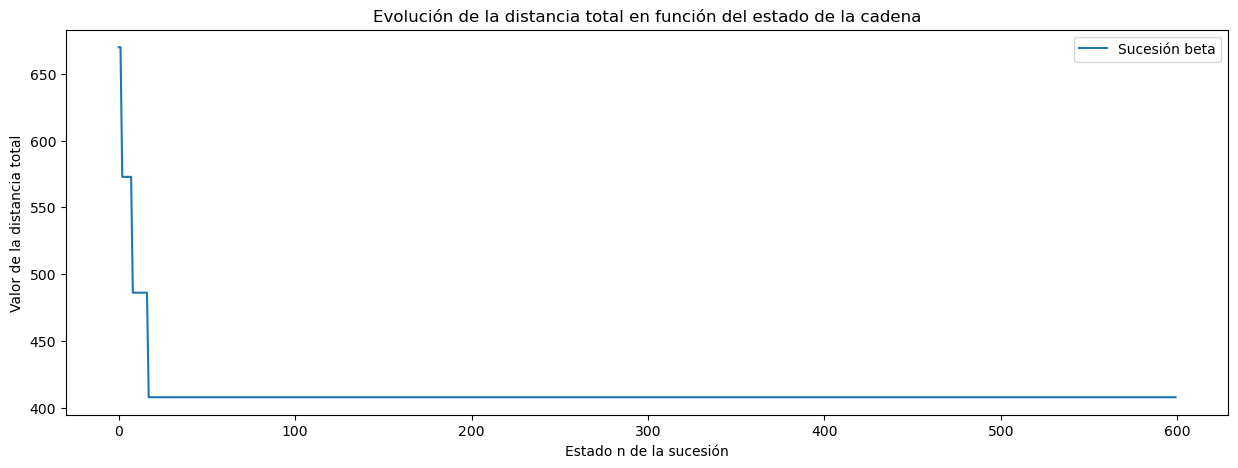

In [17]:
indices = range(N_markov)
# beta_n distintos, desde 1 hasta N (0:N-1)
betas_lineal = [i for i in indices]
betas_quadra = [i**2 for i in indices]
betas_expnen = [np.exp(i) for i in indices]

# Parámetros a cambiar.
fn_beta = betas_expnen # betas_lineal, betas_quadra o betas_expnen

# Genero las cadenas y me quedo con la última.
Cadena_beta = simular_cadena(N_markov,estaciones,sigma_inicial,fn_beta)
# Guardo la distancia.
w_beta = [distancia_rec(estaciones,perm) for perm in Cadena_beta]
plt.figure(figsize=(15, 5))
plt.plot(indices,w_beta, label="Sucesión beta")

plt.title("Evolución de la distancia total en función del estado de la cadena")
plt.ylabel("Valor de la distancia total")
plt.xlabel("Estado n de la sucesión")
plt.legend()
plt.show()

C:\Users\nico_\AppData\Local\Temp\ipykernel_14936\3047871367.py:12: RuntimeWarning: overflow encountered in exp
  Cte_final = min(np.exp(-1*beta_n*osc_tau_sigma),1)


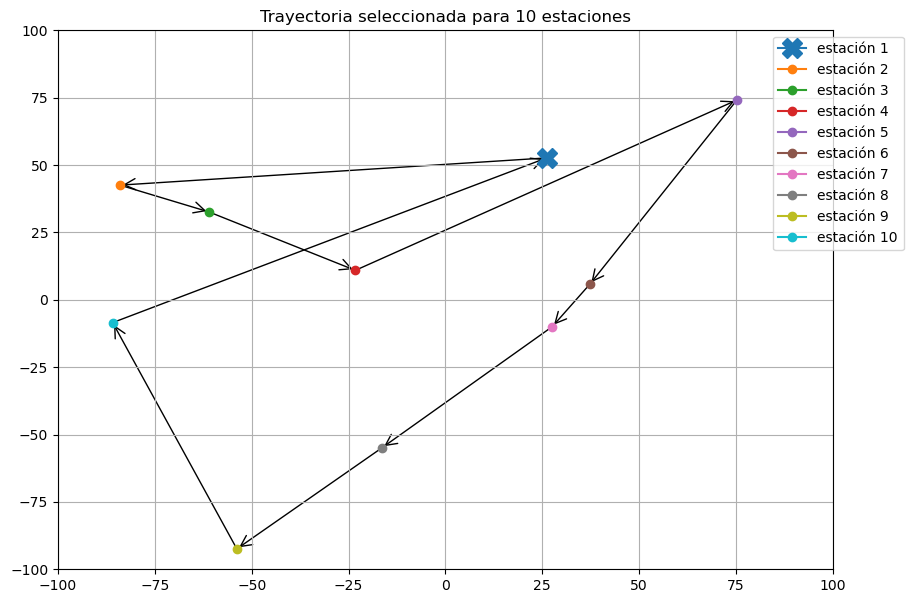

In [18]:
Cadena_lineal = simular_cadena(N_markov,estaciones,sigma_inicial,fn_beta)
sigma_f = matriz[-1]
recorre(estaciones,sigma_f)

Obteniéndose así la ruta óptima de las estaciones encontradas.

Finalmente, se pudo generar una ruta de metro socialmente eficiente, cubriendo las casas y puntos de interés y conectándolas de forma de obtener la ruta cerrada mas corta. Además, el modelo genera algunos problemas, como la distancia entre las estaciones, acumulación de estaciones y viajes que demorarían mas tiempo. Y, por último, la tendencia de las estaciones brinda certeza de la eficiencia del modelo bajos marcos teóricos y redes reales con rutas concéntricas 